## SF crime data analysis and modeling
## Author: Beibei (Ben) Wang

## In this notebook, I learned how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/sf-data/skgt-fej3/data). 

### The first part for this project is OLAP for scrime data analysis.  
### The second part is unsupervised learning for spatial data analysis.   
### The optional part is the time series data analysis (50 credits).  
### **Note**: I used a small data sample (one month e.g. 2018-10) for debug, then downloaded the data from 2013 to 2018 for testing and analysising. 

# This project is done on databricks, and due to the fact that GitHub does not support well for the interactive plots, I published this project in the following link:
## https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/128174467911792/3641018549028490/2804558630913409/latest.html

## And for the same reason, I have to clear the output of certain cells, otherwise GitHub won't load.

In [3]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from ggplot import *
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"

## load data from official website:
#import urllib.request
#urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/sf_03_18.csv")
#dbutils.fs.mv("file:/tmp/sf_03_18.csv", "dbfs:/FileStore/tables/sf_data.csv")

In [4]:
# read data from the data storage
# please upload your data into databricks community at first. 
crime_data_lines = sc.textFile('/FileStore/tables/sf_data.csv')
#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
print(header)

#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

#get the total number of data 
print(crimes.count())

## show data
#display(dbutils.fs.ls("dbfs:/FileStore/tables/sf_data.csv"))
#display(crimes.take(3))

['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh', ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv', ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx', ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq', ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e', ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7', ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi', ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4']
2215024

### Solove  big data issues via Spark
approach 1: use RDD (not recommend)  
approach 2: use Dataframe, register the RDD to a dataframe (recommend for DE)  
approach 3: use SQL (recomend for data analysis or DS， 基础比较差的同学)  
***note***: you only need to choose one of approaches as introduced above

#### We provide 3 options to transform distributed data into dataframe and SQL table, you can choose any one of them to practice

In [ ]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/sf_data.csv")
display(df_opt1)
df_opt1.createOrReplaceTempView("sf_crime")

In [ ]:

from pyspark.sql import Row

def createRow(keys, values):
  assert len(keys) == len(values)
  mapped = dict(zip(keys, values))
  return Row(**mapped)

rdd_rows = crimes.map(lambda x: createRow(header, x))

df_opt2 = spark.createDataFrame(rdd_rows)
df_opt2.createOrReplaceTempView("sf_crime")
display(df_opt2)

In [ ]:

df_opt3 = crimes.toDF(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
df_opt3.createOrReplaceTempView("sf_crime")
df_opt3 = df_opt3[df_opt3.columns[0:13]] ## remove redundent colomns
display(df_opt3)

In [10]:
df_opt3.describe()

Out[ 9 ]: DataFrame[summary: string, IncidntNum: string, Category: string, Descript: string, DayOfWeek: string, Date: string, Time: string, PdDistrict: string, Resolution: string, Address: string, X: string, Y: string, Location: string, PdId: string]

#### Q1 question (OLAP): 
#####Write a Spark program that counts the number of crimes for different category.

Below are some example codes to demonstrate the way to use Spark RDD, DF, and SQL to work with big data. You can follow this example to finish other questions.

In [12]:

catorgory_set_rdd = crimes.map(lambda item: (item[1],1))
from operator import add
result = sorted(catorgory_set_rdd.reduceByKey(add).collect(), key = lambda item: -item[1])
display(result)

_1,_2
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [13]:
q1_result = df_opt3.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


In [14]:
#Spark SQL based
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


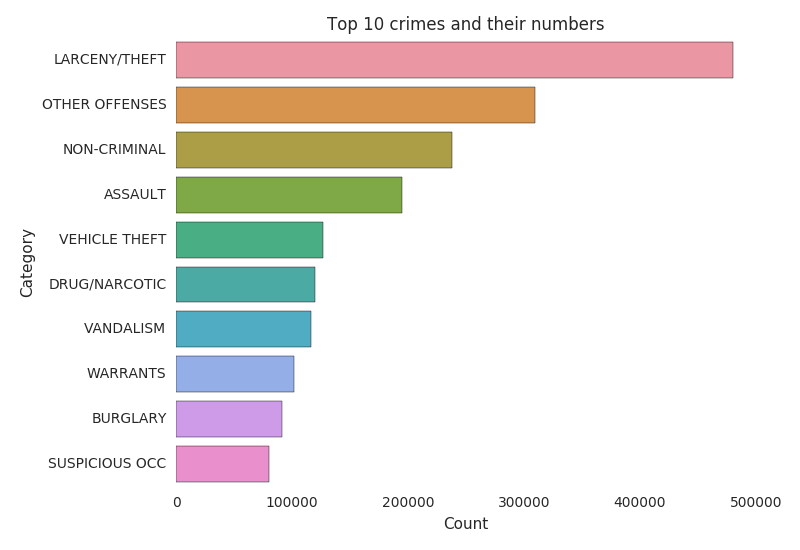

In [15]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

## select top 10 crimes:
crimeCategory.createOrReplaceTempView("crime_category_and_count")
top10= spark.sql("SELECT * FROM crime_category_and_count LIMIT 10")
top_10_crimes = top10.toPandas()

## plot:
fig, axis = plt.subplots(1,1)
sb.barplot(x = "Count", y = "category", data = top_10_crimes)
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 10 crimes and their numbers")
plt.tight_layout()
display(plt.show())


#### Q2 question (OLAP)
Counts the number of crimes for different district, and visualize your results

In [17]:
q2_db_sol = df_opt3.groupBy('PdDistrict').count().orderBy('count', ascending=True)
display(q2_db_sol)

PdDistrict,count
,1
RICHMOND,116818
PARK,125479
TARAVAL,166971
TENDERLOIN,191746
INGLESIDE,194180
BAYVIEW,221000
CENTRAL,226255
NORTHERN,272713
MISSION,300076


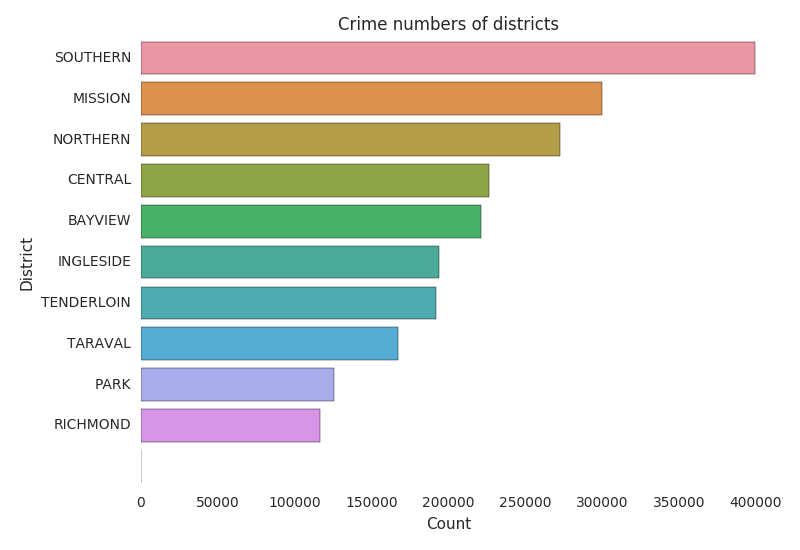

In [18]:
crimeDistrict = spark.sql("SELECT PdDistrict, COUNT(*) AS Count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC")
##display(crimeCategory)
crimeDistrict_pd = crimeDistrict.toPandas()
fig, axis = plt.subplots(1,1)
sb.barplot(x = "Count", y = "PdDistrict", data = crimeDistrict_pd)
plt.xlabel("Count")
plt.ylabel("District")
plt.title("Crime numbers of districts")
plt.tight_layout()
display(plt.show())

#### Q3 question (OLAP)
Count the number of crimes each "Sunday" at "SF downtown".   
hints: SF downtown is defiend  via the range of spatial location. For example, you can use a rectangle to define the SF downtown, or you can define a cicle with center as well. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. You can follow the example here: https://changhsinlee.com/pyspark-udf/

In [20]:
## rename df_opt3:
crime_df = df_opt3
## (-122.401818, 37.795037) is where the Amazon SF office is, which we use as the center of 'downtown area'
## (-122.407887, 37.794902) is where the entrance of SF China town, the distance between China town and Amazon we use as 'radius'
## the squared 'radius' is: 0.000036851

def Downtown_area(x, y):
  return (float(x)- (-122.401818))**2 + (float(y)- 37.795037)**2

## filter out non-Sunday data:
q3_sunday_only = crime_df.filter(crime_df.DayOfWeek=='Sunday')

## define udf:
downtown_udf = udf(lambda x, y: Downtown_area(x, y), FloatType())

## add new column named 'Squared_Distance':
new_crime_df = q3_sunday_only.withColumn('Squared_Distance', downtown_udf('X','Y'))

## filter with squared radius of downtone area:
q3_result = new_crime_df.filter(new_crime_df.Squared_Distance < 0.000036851).groupBy('Date','DayOfWeek').count().orderBy('Date', ascending=True)

In [21]:
## top 20 crime numbers of Sundays in downtown area
top_20 = q3_result.orderBy('count', ascending=False).head(20)
top_20_pd =  spark.createDataFrame(top_20).toPandas()

## bottom 20 crime numbers of Sundays in downtown area
bott_20 = q3_result.orderBy('count', ascending=True).head(20)
bott_20_pd = spark.createDataFrame(bott_20).toPandas()

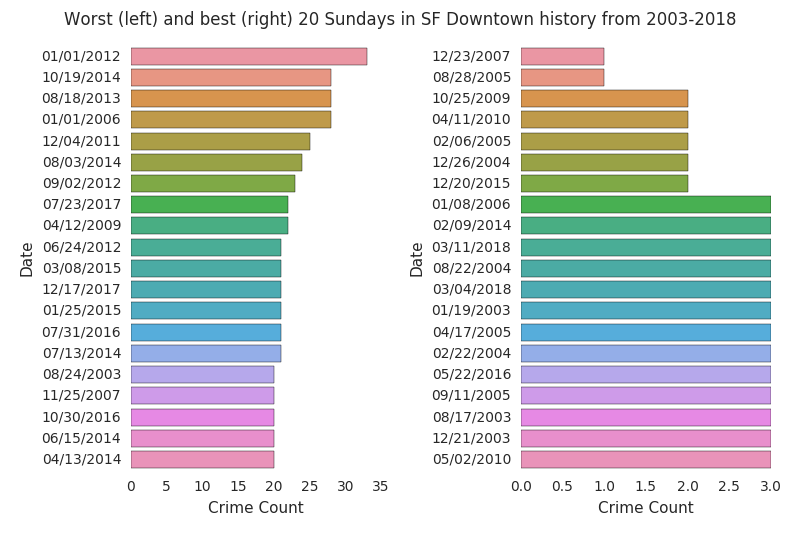

In [22]:
## plot:
fig, axes = plt.subplots(1,2)

## plot top 20 days:
sb.barplot(x = "count", y = "Date", data = top_20_pd, ax = axes[0])
axes[0].set_xlabel("Crime Count")
axes[0].set_ylabel("Date")
#axes[0].set_title("Top 20 days")

## plot bottom 20 days:
sb.barplot(x = "count", y = "Date", data = bott_20_pd, ax=axes[1])
axes[1].set_xlabel("Crime Count")
axes[1].set_ylabel("Date")
#axes[1].set_title("Bottom 20 days")

fig.suptitle("Worst (left) and best (right) 20 Sundays in SF Downtown history from 2003-2018")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
display(plt.show())

In [23]:
## pass

#### Q4 question (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

In [25]:
## import libraries to work on datetime data type:
from datetime import datetime
from pyspark.sql.functions import *

In [26]:
reformat_date = udf(lambda x: datetime.strptime(x, "%m/%d/%Y"), DateType())

## convert date string to date type:
new_crime_df = crime_df.withColumn("Date", reformat_date("Date"))

## extract hour and add it to the dataframe:
new_crime_df = new_crime_df.withColumn("Hour", hour(col("Time").cast("timestamp")))

#new_crime_df = new_crime_df.withColumn("Hour", to_timestamp(col("Time"), "HH:mm a"))
#new_crime_df.show(10)
#q4_result = new_crime_df.select(year(col('Date')).alias('Year'), month(new_crime_df.Date).alias('Month'),
#                        dayofmonth(new_crime_df.Date).alias('Day')).groupBy('Year', 'Month').count*().orderBy('Year', ascending=True)
#q4_result = new_crime_df.filter(year(new_crime_df.Date).between(2015,2016)).groupBy("Date").count().orderBy("Date", ascending=True)

## filter data: year, month, crime_count
q4_result = new_crime_df.filter(year(col('Date')).between(2015, 2018)).groupBy(year(col('Date')).alias("Year"), month(col('Date')).alias("Month")).count().orderBy(year(col('Date')), month(col('date')), ascending=True)

In [27]:
## year 2015, 2016, 2017 and 2018
year_2015 = q4_result.filter(col("Year")==2015).toPandas()
year_2016 = q4_result.filter(col("Year")==2016).toPandas()
year_2017 = q4_result.filter(col("Year")==2017).toPandas()
year_2018 = q4_result.filter(col("Year")==2018).toPandas()

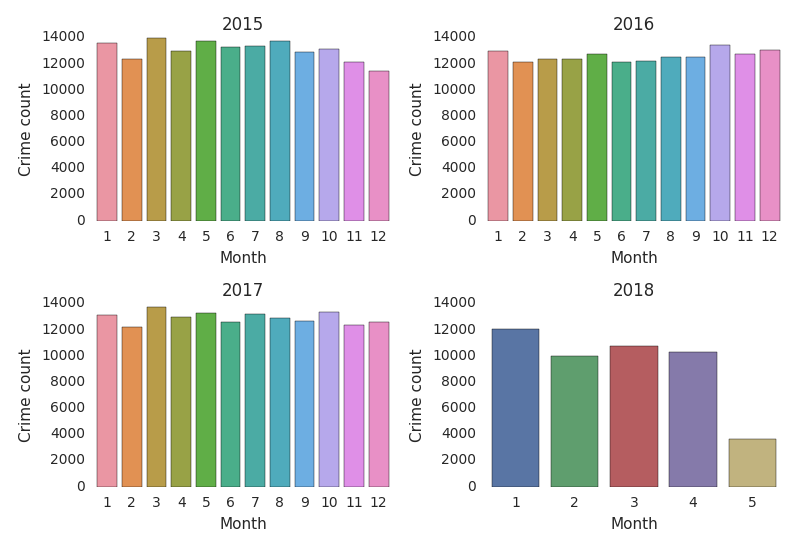

In [28]:
## plot:
fig, axes = plt.subplots(2,2)

## year 2015
sb.barplot(x = "Month", y = "count", data = year_2015, ax=axes[0,0])
axes[0,0].set_xlabel("Month")
axes[0,0].set_ylabel("Crime count")
axes[0,0].set_title("2015")

## year 2016
sb.barplot(x = "Month", y = "count", data = year_2016, ax=axes[0,1])
axes[0,1].set_xlabel("Month")
axes[0,1].set_ylabel("Crime count")
axes[0,1].set_title("2016")

## year 2017
sb.barplot(x = "Month", y = "count", data = year_2017, ax=axes[1,0])
axes[1,0].set_xlabel("Month")
axes[1,0].set_ylabel("Crime count")
axes[1,0].set_title("2017")

## year 2018
sb.barplot(x = "Month", y = "count", data = year_2018, ax=axes[1,1])
axes[1,1].set_xlabel("Month")
axes[1,1].set_ylabel("Crime count")
axes[1,1].set_title("2018")

#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
display(plt.show())

#### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. Then, give your travel suggestion to visit SF.

In [30]:
## filter the date:
q5_2015 = new_crime_df.filter(col("Date") == datetime.strptime("2015/12/15", "%Y/%m/%d")).groupby("Date", "Hour").count().orderBy("Hour", ascent=True)
q5_2016 = new_crime_df.filter(col("Date") == datetime.strptime("2016/12/15", "%Y/%m/%d")).groupby("Date", "Hour").count().orderBy("Hour", ascent=True)
q5_2017 = new_crime_df.filter(col("Date") == datetime.strptime("2017/12/15", "%Y/%m/%d")).groupby("Date", "Hour").count().orderBy("Hour", ascent=True)

## convert to Pandas dataframe
q5_2015 = q5_2015.toPandas()
q5_2016 = q5_2016.toPandas()
q5_2017 = q5_2017.toPandas()


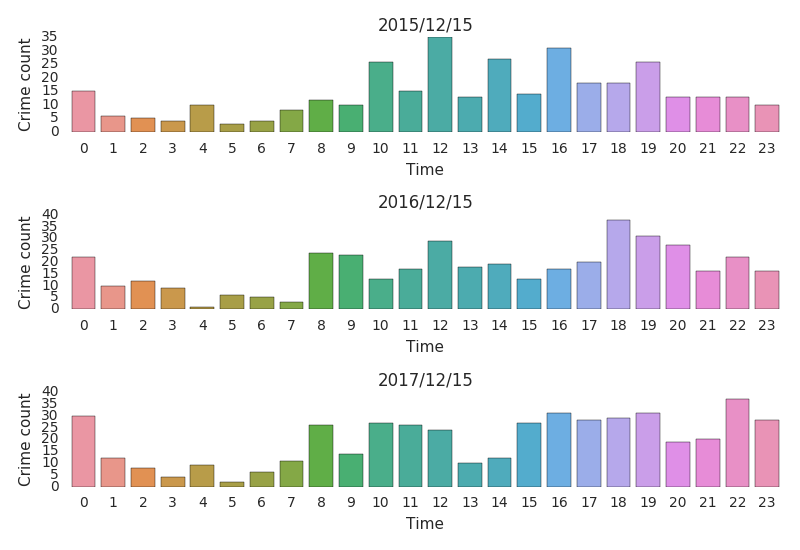

In [31]:
## plot:
fig, axes = plt.subplots(3,1)

## year 2015
sb.barplot(x = "Hour", y = "count", data = q5_2015, ax=axes[0])
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Crime count")
axes[0].set_title("2015/12/15")

## year 2016
sb.barplot(x = "Hour", y = "count", data = q5_2016, ax=axes[1])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Crime count")
axes[1].set_title("2016/12/15")

## year 2017
sb.barplot(x = "Hour", y = "count", data = q5_2017, ax=axes[2])
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Crime count")
axes[2].set_title("2017/12/15")

#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.tight_layout()
display(plt.show())

#### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [33]:
## Step 1: find out the top-3 dangerous district
top_3 = new_crime_df.groupBy(col("PdDistrict")).count().orderBy('count', ascending=False).head(3)
display(top_3)
## so the top 3 most dangerous districts: "SOUTHERN", "MISSION", "NORTHERN"

PdDistrict,count
SOUTHERN,399785
MISSION,300076
NORTHERN,272713


In [34]:
## Step 2: crime event w.r.t catetory and time in each district:

## find out the crimes in each region:

Southern = new_crime_df.filter(col("PdDistrict") == "SOUTHERN").groupBy(col("Hour").alias("Time_of_the_day"), 'Category').count().orderBy('Hour', ascending=True)

Mission  = new_crime_df.filter(col("PdDistrict") == "MISSION" ).groupBy(col("Hour").alias("Time_of_the_day"), 'Category').count().orderBy('Hour', ascending=True)

Northern = new_crime_df.filter(col("PdDistrict") == "NORTHERN").groupBy(col("Hour").alias("Time_of_the_day"), 'Category').count().orderBy('Hour', ascending=True)

In [ ]:
display(Southern)  ### barplot for crimes in Southern district

In [ ]:
display(Mission) ### barplot for crimes in Mission district

In [ ]:
display(Northern)  ### barplot for crimes in Northern district

#### Q7 question (OLAP)
For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

In [39]:
new_crime_df.show(10)

+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+----+
IncidntNum| Category| Descript|DayOfWeek| Date| Time|PdDistrict| Resolution| Address| X| Y| Location| PdId|Hour|
+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+----+
 180362289| VEHICLE THEFT| STOLEN MOTORCYCLE| Tuesday|2018-05-15|10:30| SOUTHERN| NONE|700 Block of TEHA...|-122.41191202732877| 37.77520656149669|(37.7752065614966...|18036228907023| 10|
 180360948| NON-CRIMINAL|AIDED CASE, MENTA...| Tuesday|2018-05-15|04:14| SOUTHERN| NONE|MARKET ST / SOUTH...|-122.41925789481357| 37.77514629165388|(37.7751462916538...|18036094864020| 4|
 180360879|OTHER OFFENSES| PAROLE VIOLATION| Tuesday|2018-05-15|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087926150| 2|
 180360879|OTHER OFFENSES|TRAFFIC VIOLATION...| Tuesday|2018-05-15|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087965010| 2|
 180360879|OTHER OFFENSES| TRAFFIC VIOLATION| Tuesday|2018-05-15|02:01| MISSION|ARREST, BOOKED| CAPP ST / 21ST ST|-122.41781255878655|37.757100579642824|(37.7571005796428...|18036087965015| 2|
 180360829|OTHER OFFENSES|DRIVERS LICENSE, ...| Tuesday|2018-05-15|01:27| MISSION| NONE|700 Block of SHOT...|-122.41561725232026| 37.75641376904809|(37.7564137690480...|18036082965016| 1|
 180360835| ROBBERY|ROBBERY, BODILY F...| Tuesday|2018-05-15|01:25| SOUTHERN|ARREST, BOOKED| 0 Block of 6TH ST|-122.41004163181597|37.781953653725715|(37.7819536537257...|18036083503074| 1|
 180360835| DRUG/NARCOTIC|POSSESSION OF NAR...| Tuesday|2018-05-15|01:25| SOUTHERN|ARREST, BOOKED| 0 Block of 6TH ST|-122.41004163181597|37.781953653725715|(37.7819536537257...|18036083516710| 1|
 180360794| LIQUOR LAWS|MISCELLANEOUS LIQ...| Tuesday|2018-05-15|00:19| PARK|ARREST, BOOKED|1500 Block of HAI...|-122.44776112231955| 37.76984648754153|(37.7698464875415...|18036079417030| 0|
 180360794| WARRANTS|ENROUTE TO OUTSID...| Tuesday|2018-05-15|00:19| PARK|ARREST, BOOKED|1500 Block of HAI...|-122.44776112231955| 37.76984648754153|(37.7698464875415...|18036079462050| 0|
+----------+--------------+--------------------+---------+----------+-----+----------+--------------+--------------------+-------------------+------------------+--------------------+--------------+----+
only showing top 10 rows

In [ ]:
display(new_crime_df)

In [41]:
## one method is：for each crime category，calculate the total count，then calculate the total number for resolution being None
## then devide this two dataframes to get percentage of resolution for each crime category
## possible bug: there might be crime categories that have no "None" resolution, in that case, the two dataframes don't have the same dimension
## but could use left join, put 0 as the count for those crimes that have no "None" resolution

## from here we will only work on the 2014 - 2018 part of the crime data

## first filter the data before 2014:
crime_14_to_18 = new_crime_df.filter(year(col('Date')).between(2014, 2018))

## define udf to remove white spaces in the Resolution column
none_udf = udf(lambda s: s.strip(" "), StringType())
q7_df = crime_14_to_18.withColumn("Resolution_2", none_udf("Resolution"))

total_count = crime_14_to_18.groupBy("Category").count().withColumnRenamed("count", "Total_count").orderBy("Category", ascending = True)
total_none =  q7_df.filter(col("Resolution_2") == "NONE").groupBy("Category").count().withColumnRenamed("count", "None_resolution_count").orderBy("Category", ascending = True)

In [42]:
print(total_count.count())
print(total_none.count())

39
39

In [43]:
## calculate the resolution percentage:

crime_resol_percent = (total_count.join(total_none, "Category")
                       .withColumn("Percentage_of_resolution", (total_none["None_resolution_count"]/total_count["Total_count"]*100.0))
                       .drop("count").orderBy("Percentage_of_resolution",ascending=False))

#resolution_ratio = total_none.toPandas().reset_index(drop=True) / total_count.toPandas().reset_index(drop=True) * 100

In [44]:
## crime categories with their percentage of resolution:
#top_20_resol =  spark.createDataFrame(crime_resol_percent.head(20)).toPandas()
crime_resol_precent = crime_resol_percent.toPandas()

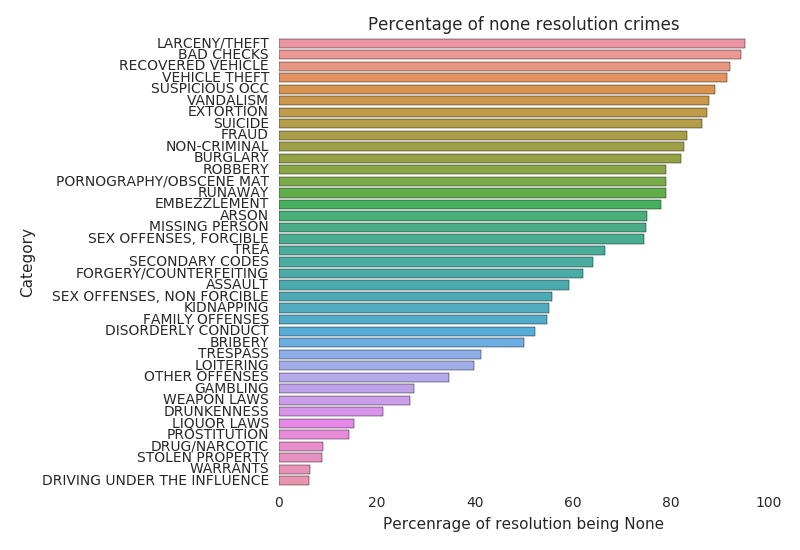

In [45]:
fig, axis = plt.subplots(1,1)
sb.barplot(x = "Percentage_of_resolution", y = "Category", data = crime_resol_precent)
plt.xlabel("Percenrage of resolution being None")
plt.ylabel("Category")
plt.title("Percentage of none resolution crimes")
plt.tight_layout()
display(plt.show())

#### Q8 question (Apply Spark ML clustering for spatial data analysis)
Extra: visualize the spatial distribution of crimes and run a kmeans clustering algorithm (please use Spark ML kmeans)  
You can refer Spark ML Kmeans a example: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [47]:
## import libraries:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

In [48]:
## select coordination of crime data:
q8_df = crime_14_to_18.select(["IncidntNum", "X","Y"])

## define udf to transfer string to float:
string_to_float = udf(lambda s: float(s), FloatType())

## apply udf to X and Y:
KNN_data = q8_df.withColumn("X", string_to_float('X'))
KNN_data = KNN_data.withColumn("Y", string_to_float('Y'))

## select features:
assembler = VectorAssembler(inputCols=["X", "Y"], outputCol="features")
KNN_data = assembler.transform(KNN_data).select("IncidntNum","features")

In [49]:
## grid search for best cluster number:
Cost_vs_k, Silhouette = [], []

for k in range(2,21):
  
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    KNN_model = kmeans.fit(KNN_data.sample(False, 0.2, seed = 42))
    cost = KNN_model.computeCost(KNN_data)
    
    Cost_vs_k.append([k, cost])
    
    print("cost for k = {} is {}".format(k, cost))
    
    ## Make predictions
    #predictions = KNN_model.transform(KNN_data)
    
    ## Evaluate clustering by computing Silhouette score
    #evaluator = ClusteringEvaluator()
    #silhouette = evaluator.evaluate(predictions)
    #Silhouette.append(silhouette)
    
    ## print to screen:
    #print("cost for k = {} is {}".format(k, cost)+", Silhouette score = "+str(silhouette))

Cost_vs_k = np.asarray(Cost_vs_k)
Silhouette = np.asarray(Silhouette) ## Silhouette score is not used here due to its ambivalence

cost for k = 2 is 467.7957000889093
cost for k = 3 is 283.1923853597516
cost for k = 4 is 231.1069538421841
cost for k = 5 is 175.94181989326387
cost for k = 6 is 143.43155498413782
cost for k = 7 is 128.97236636740755
cost for k = 8 is 113.39767188243673
cost for k = 9 is 104.99425034444802
cost for k = 10 is 89.09044698176935
cost for k = 11 is 79.33733248619035
cost for k = 12 is 73.27159697725358
cost for k = 13 is 67.61084847093038
cost for k = 14 is 63.75403544169655
cost for k = 15 is 59.504196166091404
cost for k = 16 is 55.28594261007682
cost for k = 17 is 52.810467993855895
cost for k = 18 is 48.426833214277906
cost for k = 19 is 47.476359362861984
cost for k = 20 is 43.29468167664908

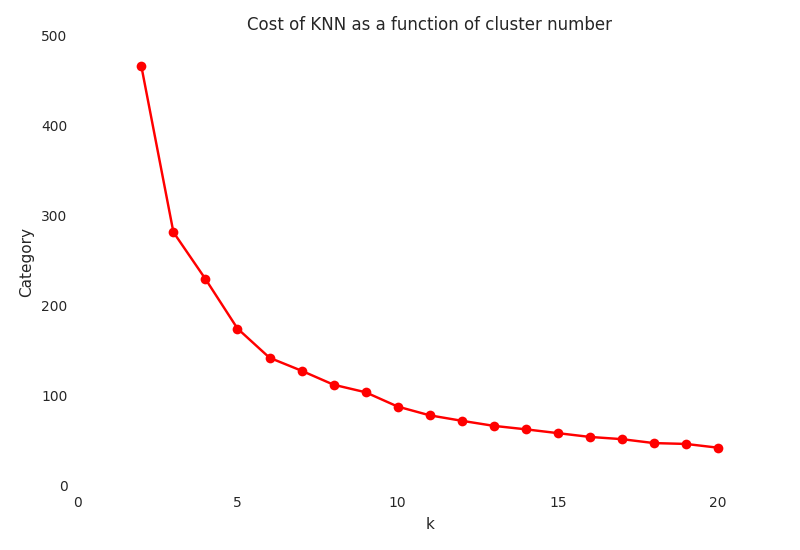

In [50]:
## plot the cost against k value

fig, axis = plt.subplots(1,1)
plt.plot(Cost_vs_k[:,0], Cost_vs_k[:,1], 'r-o')
plt.xlabel("k")
plt.xlim(0,22)
plt.ylabel("Category")
plt.title("Cost of KNN as a function of cluster number")
plt.tight_layout()
plt.grid()
display(plt.show())


In [51]:
## chose k to be 16, for example
kmeans = KMeans().setK(16).setSeed(1).setFeaturesCol("features")
KNN_model = kmeans.fit(KNN_data)

# Shows the centroids:
centroids = KNN_model.clusterCenters()
print("Cluster centroids: ")
for center in centroids:
    print(center)

Cluster centroids: 
[-122.50196192 37.77062934]
[-122.43250547 37.7209639 ]
[-122.44859382 37.77372409]
[-122.40230076 37.78274328]
[-122.46808027 37.75531616]
[-122.39988585 37.75669196]
[-122.42023704 37.74580861]
[-122.47118206 37.77933642]
[-122.46606292 37.72179418]
[-122.43289475 37.79289397]
[-122.41555913 37.7828179 ]
[-122.41702009 37.76545135]
[-122.408565 37.801051]
[-122.43224466 37.7688074 ]
[-122.39288602 37.7289821 ]
[-122.48986478 37.74182344]

In [ ]:
## assign each row to its centroids:
KNN_pred = KNN_model.transform(KNN_data).select("IncidntNum", "features", "prediction")

## put together with KNN_data:
data_with_pred = q8_df.join(KNN_pred, ["IncidntNum"])#.drop("features")
display(data_with_pred)

In [ ]:
print(data_with_pred.count())
display(q8_df)

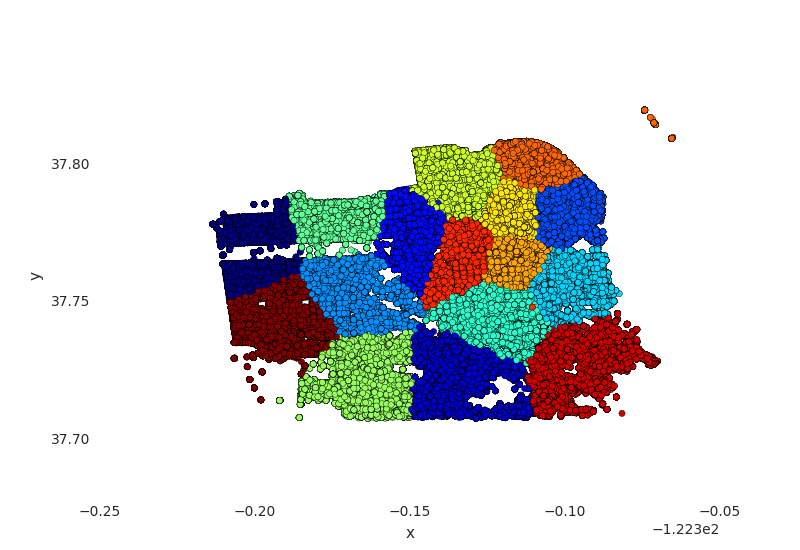

In [54]:
#data_with_pred_pd = spark.createDataFrame(data_with_pred.head(1000))

## apply udf string_to_float to X and Y:
new_data = data_with_pred.withColumn("X", string_to_float("X"))
new_data = new_data.withColumn("Y", string_to_float("Y"))
new_data = new_data.toPandas()

fig, axis = plt.subplots()
plt.scatter(new_data.X, new_data.Y, c = new_data.prediction, cmap = 'jet', alpha = 1.0)
plt.xlabel('x')
plt.ylabel('y')
display(plt.show())

## Conclusion:
### In this project, I used Spark framework to perform analysis on the police department incident report dataset from 2003 to May 2018, in order to get trained with Spark and get insight in the crime events happened in San Francisco history.

### I applied UDF (User Defined Function) to Spark dataframe, and clean and filter the data, including removing redundent strings (white spaces, commas, etc.), then I visualized the data with barcharts and plots, based on numers, locations and time of the crimes and incidents to get insights and travel suggestins for visotors.

### Finally I applied unsupervised learning (distributed Spark K-Means algorihtm) to cluster the crime data, and categorized the crime data based on their locations.

## Optional part: Time series analysis
### This part is not based on Spark, and only based on Pandas Time Series package.   
### 1.visualize time series  
### 2.plot ACF and find optimal parameter  
### 3.Train ARIMA  
### 4.Prediction 

## References:   
https://zhuanlan.zhihu.com/p/35282988  
https://zhuanlan.zhihu.com/p/35128342  
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3  
https://www.joinquant.com/post/9576?tag=algorithm  
https://blog.csdn.net/u012052268/article/details/79452244